In [9]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [10]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [11]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [12]:
# Create path to sqlite
database_path = "../Resources/hawaii.sqlite"
# Create engine to hawaii.sqlite
engine = create_engine(f"sqlite:///{database_path}")

In [13]:
# Reflect an existing database into a new model
Base = automap_base()

# Reflect the database tables
Base.prepare(engine, reflect=True)

In [14]:
# View all of the classes that automap found
Base.classes.items()

[('measurement', sqlalchemy.ext.automap.measurement),
 ('station', sqlalchemy.ext.automap.station)]

In [15]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [16]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Precipitation Analysis

In [17]:
# Find the most recent date in the data set
recent_date = session.query(func.max(measurement.date)).first()[0]
recent_date

'2017-08-23'

In [18]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
one_year = dt.datetime.strptime(recent_date,"%Y-%m-%d") - dt.timedelta(days=365)
one_year_str = one_year.strftime("%Y-%m-%d")
print("One year from last date in data set: ", one_year_str)

One year from last date in data set:  2016-08-23


In [19]:
# Perform a query to retrieve the date and precipitation scores
one_year = session.query(measurement.date, measurement.prcp).filter(measurement.date >= one_year_str).all()
one_year

[('2016-08-23', 0.0),
 ('2016-08-24', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0),
 ('2016-08-28', 0.01),
 ('2016-08-29', 0.0),
 ('2016-08-30', 0.0),
 ('2016-08-31', 0.13),
 ('2016-09-01', 0.0),
 ('2016-09-02', 0.0),
 ('2016-09-03', 0.0),
 ('2016-09-04', 0.03),
 ('2016-09-05', None),
 ('2016-09-06', None),
 ('2016-09-07', 0.05),
 ('2016-09-08', 0.0),
 ('2016-09-09', 0.03),
 ('2016-09-10', 0.0),
 ('2016-09-11', 0.05),
 ('2016-09-12', 0.0),
 ('2016-09-13', 0.02),
 ('2016-09-14', 1.32),
 ('2016-09-15', 0.42),
 ('2016-09-16', 0.06),
 ('2016-09-17', 0.05),
 ('2016-09-18', 0.0),
 ('2016-09-19', 0.0),
 ('2016-09-20', 0.0),
 ('2016-09-21', 0.0),
 ('2016-09-22', 0.02),
 ('2016-09-23', 0.0),
 ('2016-09-24', 0.0),
 ('2016-09-25', 0.0),
 ('2016-09-26', 0.06),
 ('2016-09-27', 0.02),
 ('2016-09-28', 0.0),
 ('2016-09-29', 0.0),
 ('2016-09-30', 0.0),
 ('2016-10-01', 0.0),
 ('2016-10-02', 0.0),
 ('2016-10-03', 0.0),
 ('2016-10-04', 0.0),
 ('2016-10-05', 0.0),
 ('2016-10-06'

In [20]:
# Save the query results as a Pandas DataFrame and set the index to the date column
query_df = pd.DataFrame(one_year).rename(columns={"prcp":"Precipitation", "date":"Date"})
query_df.set_index("Date", inplace = True)
query_df.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


In [21]:
# Sort the dataframe by date
query_df.sort_index(inplace=True)
query_df.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


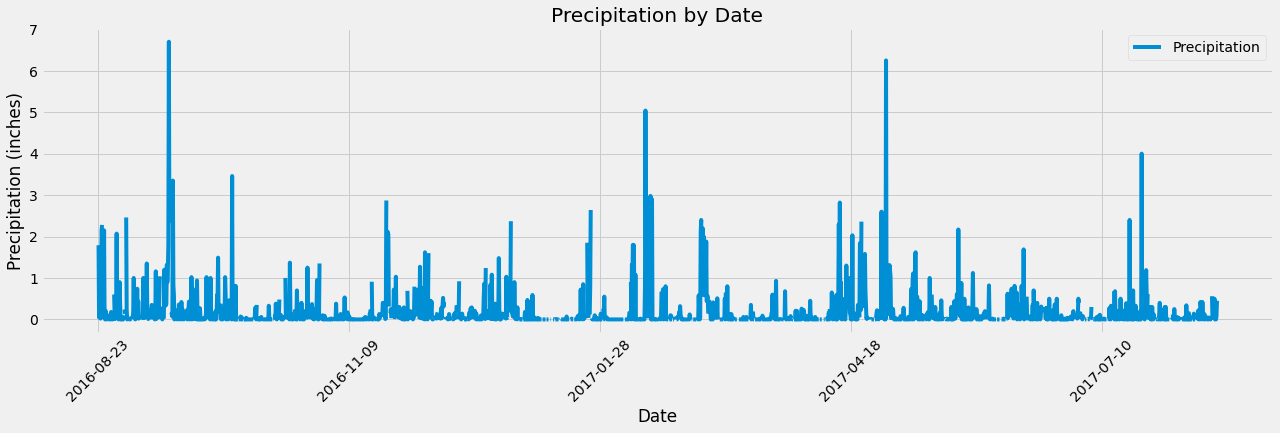

In [22]:
# Use Pandas Plotting with Matplotlib to plot the data
fig,ax=plt.subplots()
query_df.plot(ax=ax, rot=45, figsize=(18,6))
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.tight_layout()
plt.title("Precipitation by Date")
plt.savefig("../Images/preciptation_past_year.png")
plt.show()

In [23]:
# Use Pandas to calculate the summary statistics for the precipitation data
query_df.describe()


,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [24]:
# Design a query to calculate the total number stations in the dataset
session.query(measurement.station).group_by(measurement.station).count()


9

In [25]:
# Design a query to find the most active stations 
# List the stations and the counts in descending order.
count_per_station = session.query(measurement.station,func.count(measurement.station)).\
        group_by(measurement.station).\
            order_by(func.count(measurement.station).desc()).all()
count_per_station


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [26]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).filter(measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

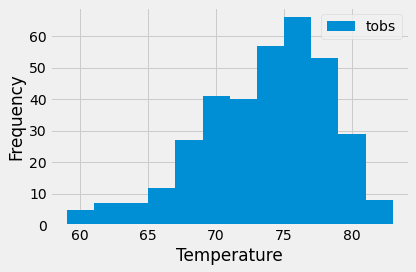

In [27]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
query = session.query(measurement.tobs).filter(measurement.station == 'USC00519281', measurement.date >= '2016-08-23').order_by(measurement.date).all()

query_df = pd.DataFrame(query, columns=['tobs'])
query_df.plot.hist(bins=12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.tight_layout()

# Close session

In [28]:
# Close Session
session.close()